# Neural network architecture selection

## Contents
* [Task description](#Task-description)
* [The parameters studied](#The-parameters-studied)
* [Parameters Value Area](#Parameters-Value-Area)
* [Metrics](#Metrics)
* [Dataset loading](#Dataset-loading)
* [Creating a model template](#Creating-a-model-template)
* [Creating a research object](#Creating-a-research-object)
* [Results](#Results)
* [Conclusion](#Conclusion)



## Task description

To study the effect of neural net architecture and kernel size for the task of circle center detection defined [here](../../model_examples/regression_model/model_description.ipynb) and choose the optimal model.


## The parameters studied
Kernel size in convolutial layers and network architecture.


## Parameters Value Area
* __Models__: Inception_v3, MobileNet, ResNet34
* __Kernel size in ResNet34__: 3х3, 5х5, 7х7


## Metrics
The metric is MSE (mean squared error) on the test and on the training part of the dataset.

In [1]:
import os
import sys
sys.path.insert(0, os.path.join("..", ".."))

from batchflow import Dataset, Pipeline, V, C, B
from batchflow.research import Option, Research, Resutls
from batchflow.models.tf import Inception_v3, MobileNet, ResNet34

from src import ShapesBatch, get_mse, show_research

# Dataset loading

In [3]:
imset = Dataset(1000, ShapesBatch)

# Creating a model template
Define model config

In [ ]:
# Объявление констант
BATCH_SIZE = 50
N_REPS = 3
N_ITERS = 120

In [4]:
model_config = {
    'inputs/images/shape': B('image_shape'),
    'inputs/labels/shape': 2,
    'initial_block/inputs': 'images',
    'body/block/kernel_size': C('kernel_size'),
    'loss': 'mse',
    'optimizer': 'Adam'
}

Define train and test pipeline and set parameters of lazy run with BATCH_SIZE = 50

In [3]:
BATCH_SIZE = 50
IMAGE_SIZE = 128

In [5]:
train_pipeline  = (imset.p
                   .init_variable('loss', init_on_each_run=list)                   
                   .init_model('dynamic', C('model'), 'model', config=model_config)
                   .sample_images(IMAGE_SIZE, max_r=24)
                   .train_model('model', fetches='loss',
                                images=B('images'), labels=B('labels'),
                                save_to=V('loss', mode='w'))
                   .run_later(BATCH_SIZE, shuffle=True, n_epochs=None)
)
test_pipeline = (imset.p
                 .init_variable('predictions', init_on_each_run=list)
                 .init_variable("targets", init_on_each_run=list)
                 .import_model('model', C('import_from'))
                 .sample_images(IMAGE_SIZE)
                 .update_variable('targets', B('labels'), mode='e')
                 .predict_model('model', fetches='predictions',
                                images=B('images'),
                                save_to=V('predictions', mode='e'))
                 .run_later(BATCH_SIZE, shuffle=False, n_epochs=1)
)

# Creating a research object


Set the parameters for research execution:

For each parameter set perform NUM_ITERS=120 iterations of train pipeline with model performance evaluation every 12 iterations. Repeat this procedure NUM_REPEAT=3 times.

We add to the research a function get_mse that gets results of the test pipeline and will be executed every 12 iterations.

Results of the research execution will be saved in the directory __combination_research__

In [6]:
opts = Option('model', [Inception_v3, MobileNet]) \
       + Option('model', [ResNet34]) * Option('kernel_size', [3, 5, 7])

research = (Research()
            .add_pipeline(train_pipeline, variables='loss', name='train')
            .add_pipeline(test_pipeline, name='test', execute='%12',
                          run=True, import_from='train')
            .add_function(get_mse, returns='loss', name='test_mse',
                          execute='%12', pipeline='test')
            .add_grid(opts)
)

Run research:

In [2]:
N_REPS = 3
N_ITERS = 120

In [7]:
research_name = 'combination_research'
research.run(n_reps=N_REPS, n_iters=N_ITERS, name=research_name, bar=True)

Research combination_research is starting...


  0%|          | 0/1800 [00:00<?, ?it/s]

Distributor has 15 jobs with 120 iterations. Totally: 1800


100%|██████████| 1800/1800 [24:30<00:00,  1.22it/s]


# Results
Loss functions vs a number of iterations for each parameters set:

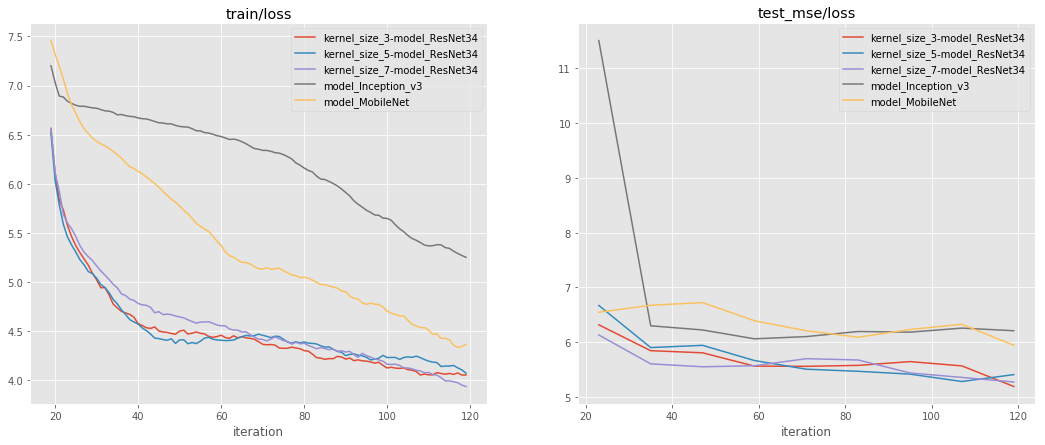

In [8]:
data = Results(path=research_name).load(use_alias=True)
show_research(data, average_repetitions=True, log_scale=[True, True],
              layout=['train/loss', 'test_mse/loss'], rolling_window=[20, 2])

# Conclusion

Models Inception v3 and MobileNet converge more slowly than ResNet34.

ResNet34 with different kerlel size show approximately no difference in quality and rate of convergence therefore it is better to choose the model with the least number of parameters, i.e. __ResNet34 with kernel size 3х3.__